<a href="https://colab.research.google.com/github/KKawaguchi1219/Frog-Oscillator/blob/main/FrogOscillator_SWanalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Γ_mn(r_m, r_n, θ_m, θ_n, K_mn=1):
    return -K_mn/(np.linalg.norm(r_m-r_n)**2)*np.sin(θ_m-θ_n)

In [3]:
def F_mn(r_m, r_n, θ_m, θ_n, K_mn=1):
    r_mn = r_m-r_n
    e_mn = r_mn/np.linalg.norm(r_mn)
    return -K_mn/(np.linalg.norm(r_mn)**2)*(1-np.cos(θ_m-θ_n))*e_mn

In [4]:
def G_n(r_n, L):
    e_n = r_n/np.linalg.norm(r_n)
    return (L-np.linalg.norm(r_n))*e_n

In [5]:
def KLdiv_norm(µ1, µ2):
    return (µ1-µ2)**2/2

In [6]:
def Kmn_calc(µ_m, µ_n, r_m, r_n, c=1, k=1, c_kl=1e-4):
    return k/(c_kl*KLdiv_norm(µ_m, µ_n)+c)

In [7]:
# K_mn/r_mn^2と相互作用の組を取り出したい
def frog_oscillator_SW(theta, x, y, N, L, omega, µ, c_kl, freqs):

    r = np.stack([x, y], axis=1)

    dtheta = np.full(N, omega)
    dr = np.zeros((N, 2))
    dx = np.zeros(N)
    dy = np.zeros(N)

    for i in range(N):

        # リンクを作る自分以外の2匹を選択
        distances = np.linalg.norm(r - r[i], axis=1)
        distances[i] = np.inf
        neighbors = np.argpartition(distances, 2)[:2]

        # 鳴き声の位相のみネットワーク上の3匹のみで計算
        for j in neighbors:
            assert i!=j, "i must not be j."

            K_mn = Kmn_calc(freqs[i], freqs[j], r[i], r[j], c_kl=c_kl)
            # phase
            dtheta[i] += Γ_mn(r[j], r[i], theta[j], theta[i], K_mn=K_mn)

        # 座標の計算は全てのカエルに対して計算する
        for j in range(N):
            if i==j: continue

            K_mn = Kmn_calc(freqs[i], freqs[j], r[i], r[j], c_kl=c_kl)
            # location
            dr[i] += F_mn(r[j], r[i], theta[j], theta[i], K_mn=K_mn)

        dr[i] += G_n(r[i], L)

        dx[i] = dr[i, 0]
        dy[i] = dr[i, 1]

    return dtheta, dx, dy


In [8]:
def rk4_step(theta, x, y, dt, N, L, omega, µ, c_kl, freqs):
    """RK4法による1ステップ更新"""
    def get_k(theta, x, y):
        return frog_oscillator_SW(theta, x, y, N, L, omega, µ, c_kl, freqs)

    k1_theta, k1_x, k1_y = get_k(theta, x, y)
    k2_theta, k2_x, k2_y = get_k(theta+0.5*dt*k1_theta, x+0.5*dt*k1_x, y+0.5*dt*k1_y)
    k3_theta, k3_x, k3_y = get_k(theta+0.5*dt*k2_theta, x+0.5*dt*k2_x, y+0.5*dt*k2_y)
    k4_theta, k4_x, k4_y = get_k(theta+dt*k3_theta, x+dt*k3_x, y+dt*k3_y)

    theta_next = theta + dt/6*(k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)
    x_next = x + dt/6*(k1_x + 2*k2_x + 2*k3_x + k4_x)
    y_next = y + dt/6*(k1_y + 2*k2_y + 2*k3_y + k4_y)

    return theta_next, x_next, y_next

In [31]:
N = 12              # カエルの個体数
L = 20              # 円の半径
omega = 4*2*np.pi   # 自然周波数

µ = np.array([2e3, 3.5e3])                                          # 鳴き声の周波数(正規分布)の平均
freqs = np.array([µ[0] if i < N // 2 else µ[1] for i in range(N)])  # 各カエルへの周波数の割り当て
c_kl = 1e-4                                                         # 相互作用の強さ

np.random.seed(0)
# カエルの初期配置
x = np.random.uniform(-L+5, L+5, N)
y = np.random.uniform(-L+5, L+5, N)

# 初期位相（ランダム設定）
theta1_init = np.random.normal(np.pi, 0.5, N//2)
theta2_init = np.random.normal(np.pi, 0.5, N//2)

# 初期状態まとめ
theta = np.concatenate([theta1_init, theta2_init])

t_max=1000
dt=1

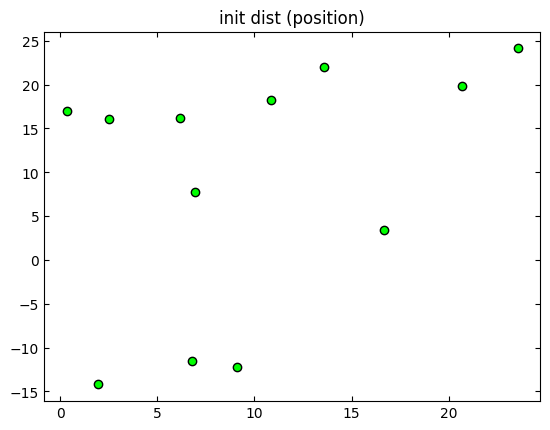

In [32]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_title('init dist (position)')

r_init = np.stack([x, y], axis=1)
ax.scatter(r_init[:, 0], r_init[:, 1], c='lime', ec='k')
plt.show()

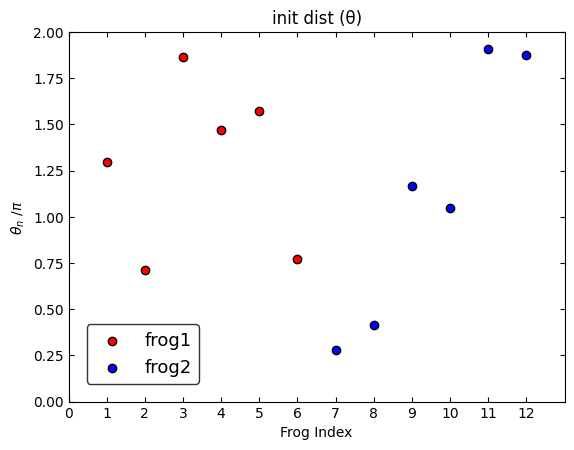

In [33]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(0, N+1)
ax.set_ylim(0, 2)
ax.set_xlabel("Frog Index")
ax.set_ylabel(r'$\theta_n\ /\pi$')
ax.set_xticks(np.arange(N+1))
ax.set_title('init dist (θ)')

ax.scatter(np.arange(N//2)+1, (theta1_init % 2*np.pi)/np.pi, c='r', ec='k', label='frog1')
ax.scatter(np.arange(N//2, N)+1, (theta2_init % 2*np.pi)/np.pi, c='b', ec='k', label='frog2')
ax.legend(edgecolor='k', fontsize=13, borderaxespad=1)
plt.show()

In [34]:
theta_hist = np.zeros((t_max, N))
x_hist = np.zeros((t_max, N))
y_hist = np.zeros((t_max, N))

for t in range(t_max):
    theta_hist[t] = theta
    x_hist[t] = x
    y_hist[t] = y
    theta, x, y = rk4_step(theta, x, y, dt, N, L, omega, µ, c_kl, freqs)

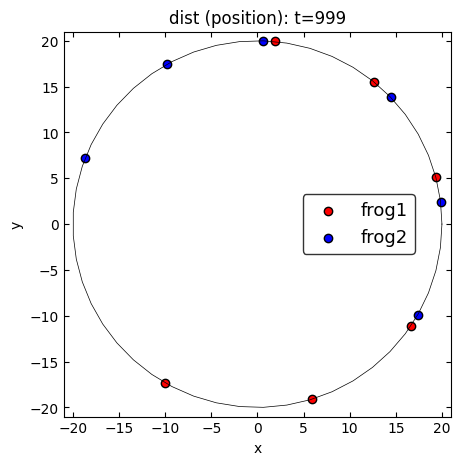

In [36]:
time = int(t_max-1)

x_anystep = x_hist[t]
y_anystep = y_hist[t]

fig, ax=plt.subplots(figsize=(5, 5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-L-1, L+1)
ax.set_ylim(-L-1, L+1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"dist (position): t={t}")

ax.plot(L*np.cos(np.linspace(0, 2*np.pi)), L*np.sin(np.linspace(0, 2*np.pi)), lw=0.5, c='k')

ax.scatter(x_anystep[:N//2], y_anystep[:N//2], c='r', ec='k', label='frog1')
ax.scatter(x_anystep[N//2:N], y_anystep[N//2:N], c='b', ec='k', label='frog2')
ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)

plt.show()

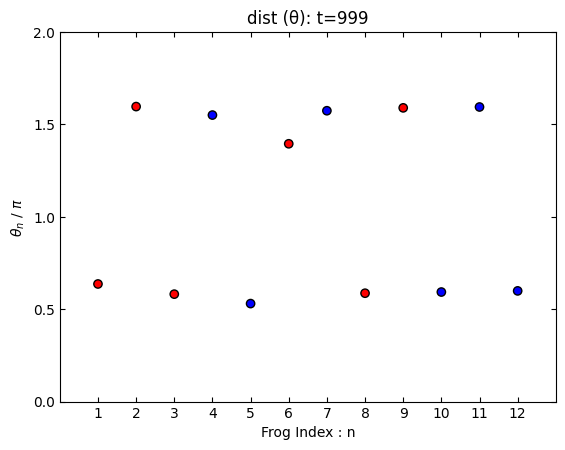

In [38]:
fig, ax = plt.subplots()

n=np.arange(N)+1

ax.set_ylim(0, 2)
ax.set_xlim(0, N+1)
ax.set_xticks(n)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Frog Index : n")
ax.set_ylabel(r"$\theta_n \ /\ \pi$")
ax.set_title(f"dist (θ): t={time}")

# 任意の時刻での位相データ
θ_anystep = theta_hist[t]

# 空間的な角度を元に，位相をソート
angle_equ_frog = np.atan2(y_anystep, x_anystep)
sort_indices = np.argsort(angle_equ_frog)
θ_anystep_sorted = θ_anystep[sort_indices]

# 色分け
colors = np.array(['red' if i < N // 2 else 'blue' for i in range(N)])
color_sorted = colors[sort_indices]

ax.scatter(n, (θ_anystep_sorted % (2*np.pi))/np.pi, c=color_sorted, ec='k')

plt.show()

In [39]:
# 周波数が同じ種間のR_{cluster}とR_{in}を計算

R_cluster_frog1, R_cluster_frog2, R_in_frog1, R_in_frog2 = [], [], [], []

for t in range(t_max):
    theta_i_step = theta_hist[t]
    frog1_θ, frog2_θ = theta_i_step[:N//2], theta_i_step[N//2:]

    R_cluster_frog1.append(np.abs(np.mean(np.exp(1j * 2 * frog1_θ))))
    R_cluster_frog2.append(np.abs(np.mean(np.exp(1j * 2 * frog2_θ))))
    R_in_frog1.append(np.abs(np.mean(np.exp(1j * frog1_θ))))
    R_in_frog2.append(np.abs(np.mean(np.exp(1j * frog2_θ))))

In [40]:
# 全てのカエルのR_{cluster}とR_{in}を計算

R_cluster, R_in = [], []

for t in range(t_max):
    theta_i_step = theta_hist[t]
    R_cluster.append(np.abs(np.mean(np.exp(1j * 2 * theta_i_step))))
    R_in.append(np.abs(np.mean(np.exp(1j * theta_i_step))))

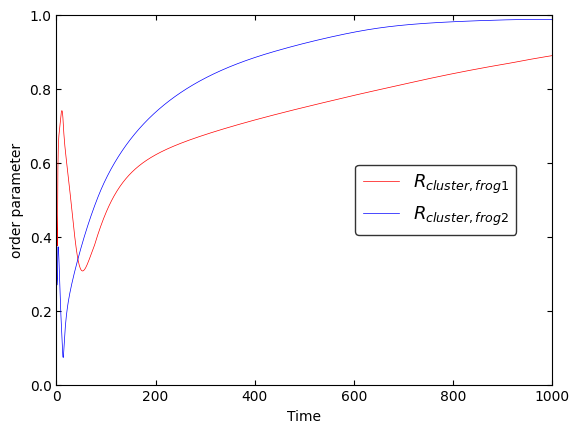

In [43]:
time=np.arange(t_max)
# n=np.arange(1, N+1)

fig, ax = plt.subplots()
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(time, R_cluster_frog1, c='r', lw=0.5, label=r'$R_{cluster, frog1}$')
ax.plot(time, R_cluster_frog2, c='b', lw=0.5, label=r'$R_{cluster, frog2}$')

ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

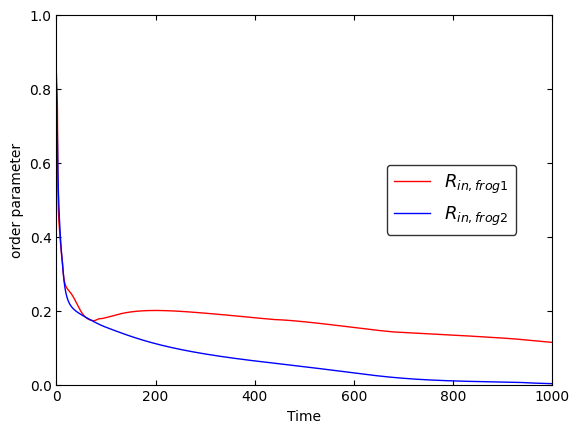

In [44]:
fig, ax = plt.subplots()
# n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(time, R_in_frog1, c='r', lw=1, label=r'$R_{in, frog1}$')
ax.plot(time, R_in_frog2, c='b', lw=1, label=r'$R_{in, frog2}$')

ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

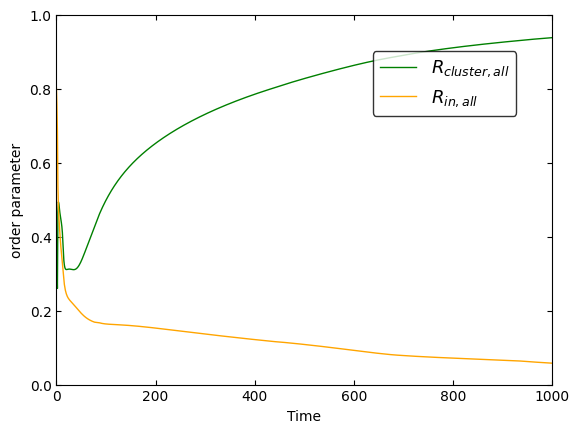

In [46]:
fig, ax = plt.subplots()

ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(time, R_cluster, c='g', lw=1, label=r'$R_{cluster, all}$')
ax.plot(time, R_in, c='orange', lw=1, label=r'$R_{in, all}$')

ax.legend(loc='upper right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()